## Assignment 5 - Erica Di Pede - 1004030336
# ***i aplogize in advance this lab is kind of a mess i had a hard time with it***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

## 1.1 Import the monthly and annual data and join 

#### 1.1.1 Importing the Data Sets **(annually)**

In [2]:
# Importing Data Sets from Assignment 3 (need to do this in different cells or else the program freezes)
annual_features = pd.read_excel('annual_features.xlsx')

In [3]:
retail_data_response = pd.read_csv('Retail_Data_Response.csv')

In [4]:
annual_day_of_week_counts_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')

#### 1.1.2 Check Dimensions, Drop Rows & Reset Index **(annually)**

In [5]:
# check the dimensions of each of the rows in the column of annual_features_outputs 
print(annual_features.shape)
print(annual_day_of_week_counts_pivot.shape)
print(retail_data_response.shape)

(6889, 41)
(6889, 36)
(6884, 2)


In [6]:
# want to find rows in retail_data_response that dont have an associated binary response that exist in annual_features
print("Index's of customers:", annual_features[~annual_features['customer_id'].isin(retail_data_response['customer_id'])].index)
print("Customer_id's of the index's:",[i for i in list(annual_features.customer_id) if not i in list(retail_data_response.customer_id) ])

Index's of customers: Int64Index([5185, 5301, 5526, 6264, 6641], dtype='int64')
Customer_id's of the index's: ['CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753']


In [7]:
annual_day_of_week_counts_pivot[~annual_day_of_week_counts_pivot['customer_id'].isin(retail_data_response['customer_id'])].index

Int64Index([5185, 5301, 5526, 6264, 6641], dtype='int64')

Notice these are the same index's as in annual features which would make sense

In [8]:
#saving the index of the rows 
rows_dnexist = annual_features[~annual_features['customer_id'].isin(retail_data_response['customer_id'])].index

In [9]:
#dropping the missing rows, we dont want a customer_id without an associated binary value
annual_features.drop(rows_dnexist, inplace=True)
annual_day_of_week_counts_pivot.drop(rows_dnexist, inplace=True)

In [10]:
#reset the index before joining
annual_features.reset_index(drop=True,inplace=True)
annual_day_of_week_counts_pivot.reset_index(drop=True,inplace=True)

#### 1.1.3 Join Tables

In [11]:
#join the three tables
annual_features_outputs = annual_features.merge(annual_day_of_week_counts_pivot, left_on='customer_id',right_on='customer_id')
annual_features_outputs = annual_features_outputs.merge(retail_data_response, left_on='customer_id',right_on='customer_id')

In [12]:
annual_features_outputs.head()

,customer_id,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,...,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday,response
0,CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,...,1,1,0,0,0,0,0,0,1,0
1,CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,...,3,0,0,2,0,0,0,0,1,0
2,CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,...,1,1,0,0,0,0,1,0,0,1
3,CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,...,0,2,0,0,0,0,1,0,0,1
4,CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,...,0,0,0,0,0,0,0,0,0,1


In [13]:
annual_features_outputs.shape

(6884, 77)

41 + 36 + 2 = 79 but the number of columns is 77, this makes sense because we are loosing the "customer_id" column from 2 datasets because you only need **one** "customer_id" column

## 1.2 Steps for each method -> **PART 1: ANNUAL** 

## **PART 1A: L1**

In [35]:
# Annual -> regression/tree/forests
# Monthly -> regression/tree/forests

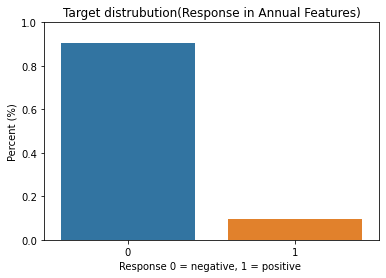

In [37]:
# overview of the responses 
sns.barplot(x="response", y="response", data=annual_features_outputs, estimator=lambda x: len(x) / len(annual_features_outputs))
plt.ylabel("Percent (%)")
plt.xlabel("Response 0 = negative, 1 = positive ")
plt.title('Target distrubution(Response in Annual Features)')
plt.ylim(0,1)
plt.show()

#### 1.2.1 Separate the inputs X and the output y in two data frames.

In [38]:
X_annual = annual_features_outputs.drop(['response','customer_id'],1)
y_annual = annual_features_outputs.response

unique_elements, counts_elements = np.unique(y_annual, return_counts=True)
print("Frequency of unique values of array")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of array
[[   0    1]
 [6237  647]]


#### 1.2.2 Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value). Use the following names for consistency.

In [39]:
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size=2/3, random_state=1147)

unique_elements, counts_elements = np.unique(y_train_annual, return_counts=True)
print("Frequency of unique values of array")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of array
[[   0    1]
 [2098  196]]


In [40]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


#### 1.2.3 Pre-Process data (Standard Scaling) standard scaling is needed for logistic regression because it it a sensitive model 

In [41]:
scaler = StandardScaler()
X_train_annual = scaler.fit_transform(X_train_annual)
X_test_annual = scaler.transform(X_test_annual)

#### 1.2.4 Fit the training dataset and optimize the hyperparameters of the method

# **i know we werent supposed to use gridsearch but i only used it here once because the 4 loop method wasnt working for some reason**

In [42]:
lr = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state=1147)

# finding best hyperparameters via gridsearch with 'roc_auc' metric
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100,1000]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)

lr.fit(X_train_annual, y_train_annual)

/Users/ericadipede/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best f1: 0.12547820295646384
The best parameter: {'C': 1000}


/Users/ericadipede/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(C=1000, penalty='l1', random_state=1147, solver='liblinear')

#### 1.2.5 Plot coeffcient values or feature importance

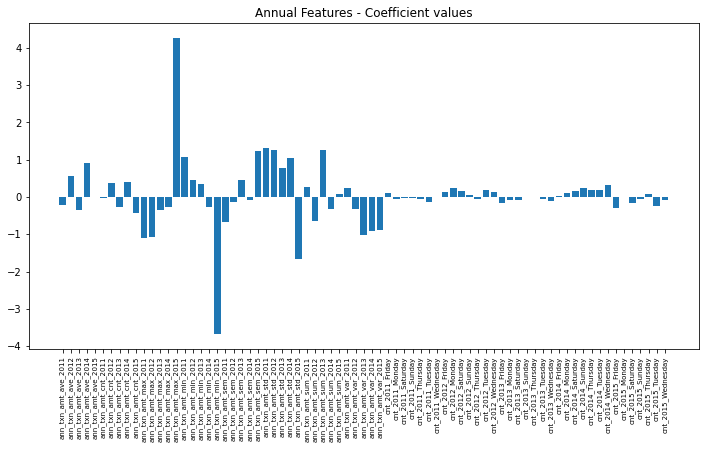

In [43]:
coeffcient = lr.coef_

plt.figure(figsize=(12,6))
plt.bar(range(X_annual.shape[1]), coeffcient[0])
plt.title("Annual Features - Coefficient values")
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=7)
plt.show()

#### 1.2.6 Plot probability distribution for test set

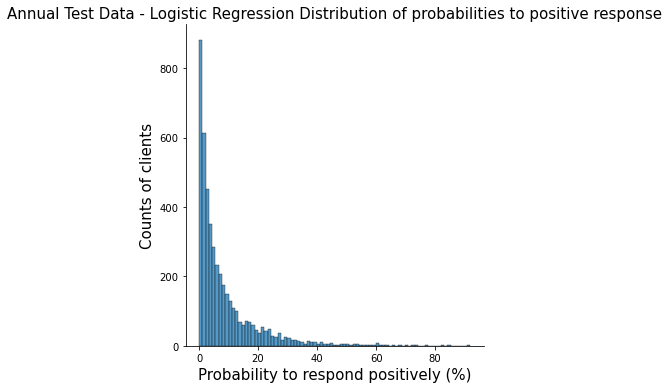

<Figure size 1440x1440 with 0 Axes>

In [44]:
y_test_proba = lr.predict_proba(X_test_annual)
sns.displot(data = y_test_proba[:,1], x = 100 * y_test_proba[:,1])
plt.title('Annual Test Data - Logistic Regression Distribution of probabilities to positive response', fontsize = 15)
plt.xlabel('Probability to respond positively (%)', fontsize = 15)
plt.ylabel('Counts of clients', fontsize = 15)
plt.figure(figsize=(20,20))
plt.show()

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall. 

Test Accuracy: 0.8930283224400871


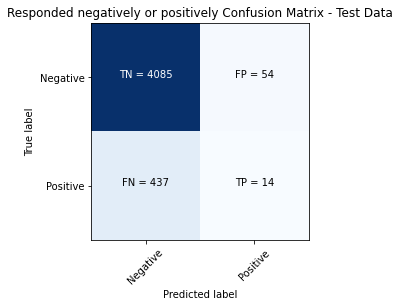

In [45]:
# Test Data 

y_test_proba = lr.predict_proba(X_test_annual)
y_test_predicted = [1 if x >= 0.45 else 0 for x in y_test_proba[:,1]]
print ('Test Accuracy:',accuracy_score(y_test_annual, y_test_predicted))
cm = confusion_matrix(y_test_annual, y_test_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix (Test Data)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()



 Train Accuracy: 0.9141238012205755


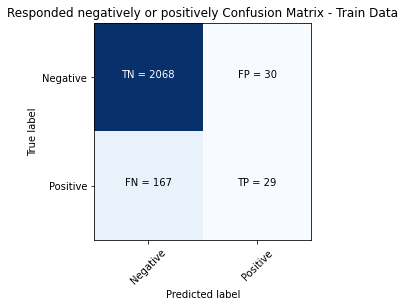

In [46]:
#  Train Data

y_train_proba = lr.predict_proba(X_train_annual)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] 
print ('\n\n Train Accuracy:',accuracy_score(y_train_annual, y_train_predicted))
cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [47]:
#Train
scores_train = lr.predict_proba(X_train_annual)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
auc_train = auc(fpr_train, tpr_train)

#Test
scores_test = lr.predict_proba(X_test_annual)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

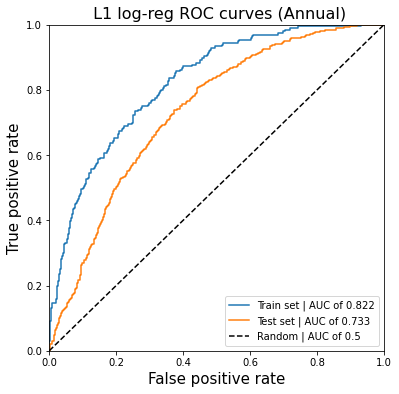

In [48]:
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title(' L1 log-reg ROC curves (Annual)', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

#### 1.2.7.3 Precision Recall

In [49]:
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative = 0', 'Positive = 1']))

              precision    recall  f1-score   support

Negative = 0       0.90      0.99      0.94      4139
Positive = 1       0.21      0.03      0.05       451

    accuracy                           0.89      4590
   macro avg       0.55      0.51      0.50      4590
weighted avg       0.83      0.89      0.86      4590



#### 1.2.8 Plot decision boundary for top 2 features.

In [50]:
min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

In [51]:
top_feature1_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-1])
top_feature2_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-2])

top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

In [52]:
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [53]:
print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature ann_txn_amt_max_2015, min=-1.1129252974988502, max=1.6245252157257768
2nd top feature ann_txn_amt_std_2011, min=-1.3302570189489547, max=3.035659940883423


In [54]:
xx, yy = np.mgrid[-2.1:2.1, -1.1:6.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  

grid dimenshion: (40, 2)


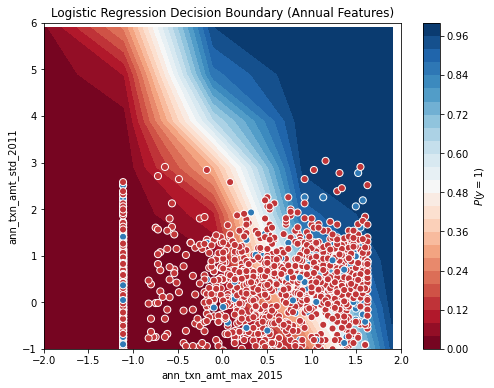

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
median_inputs = np.ones((grid.shape[0], X_train_annual.shape[1])) * np.median(X_train_annual, axis=0) 

median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
probs = lr.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual[50:,top_feature1_index], X_train_annual[50:, top_feature2_index], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Logistic Regression Decision Boundary (Annual Features)')
ax.set(aspect="auto",
       xlim=(-2, 2), ylim=(-1, 6),
       xlabel=str(top_feature1), ylabel=str(top_feature2))
plt.show()

## **PART 1B: DECISION TREES**

#### 1.1.4 Fit the training dataset and optimize the hyperparameters of the method

**Do not need to re-do steps 1-3**

In [56]:
from sklearn.tree import DecisionTreeClassifier
# parameters to track
recall_train = []
recall_test = []
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []

for i in max_depth_range:
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_annual)
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_annual)
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    recall_train.append(recall_score(y_train_annual, y_train_predicted))
    recall_test.append(recall_score(y_test_annual, y_test_predicted))

In [57]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'Recall_TRAIN': recall_train,
                          'Recall_TEST': recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,Recall_TRAIN,Recall_TEST,MAX_DEPTH
0,90.174292,0.000000,0.000000,1
1,90.174292,0.000000,0.000000,2
2,90.174292,0.005102,0.000000,3
3,89.455338,0.229592,0.077605,4
4,89.520697,0.280612,0.079823,5
5,89.259259,0.316327,0.068736,6


In [58]:
# Fit thee model using the best hyperparameter
dt = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train_annual, y_train_annual)

# Calculate feature importances
dt_feature_importances = dt.feature_importances_

#### 1.2.5 Plot coeffcient values or feature importance

 ## ***I couln't get the dates to show in the graph below so they are just by date index***

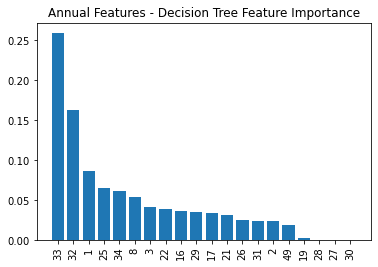

In [59]:
# Plot feature importance of top 20 features
# Sort feature importances in descending order
indices = np.argsort(dt_feature_importances)[::-1][:20]

plt.figure()
plt.title("Annual Features - Decision Tree Feature Importance")
plt.bar(range(20), dt_feature_importances[indices])
plt.xticks(range(20), indices , rotation=90)
plt.show()

In [60]:
y_test_annual_proba = dt.predict_proba(X_test_annual)

In [61]:
#plt.figure()
#sns.displot(data = y_test_annual_proba.astype(int)[:,1], x = 100*y_test_annual_proba.astype(int)[:,1])
#plt.title('Annual Features - Decision Tree Distribution of probabilities to positive response',fontsize=14)
#plt.xlabel('Probability to positive response (%)',fontsize=12)
#plt.ylabel('Counts of customers', fontsize=12)
#plt.show()

**I could not get this to work**

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall. 

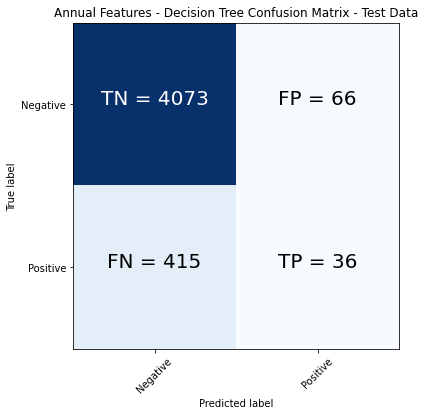

In [62]:
#Test-Data

y_test_annual_predicted = dt.predict(X_test_annual)
cm = confusion_matrix(y_test_annual, y_test_annual_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Decision Tree Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

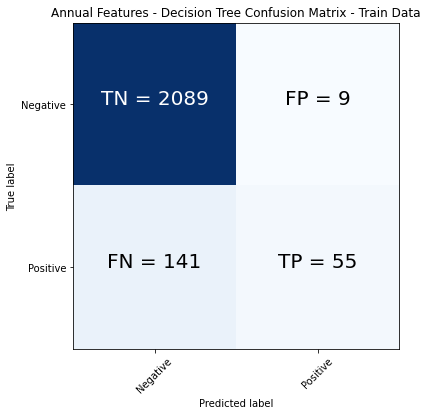

In [63]:
#Train-Data

y_train_annual_predicted = dt.predict(X_train_annual)
cm = confusion_matrix(y_train_annual, y_train_annual_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Decision Tree Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [64]:
# Scores for train set
scores_train = dt.predict_proba(X_train_annual)[:, 1]
# Scores for test set
scores_test = dt.predict_proba(X_test_annual)[:, 1]

In [65]:
# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC (Train)
auc_train = auc(fpr_train, tpr_train)
# AUC (Test)
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

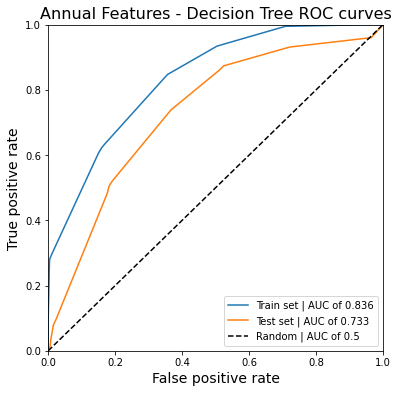

In [66]:
# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Annual Features - Decision Tree ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()


In [327]:
import warnings
warnings.filterwarnings("ignore")

# precision/recall
#print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative = 0', 'Positive = 1']))

##come back to this

#this was working when i extracted data from it for the conclusion not sure of the error

#### 1.2.8 Plot decision boundary for top 2 features.

In [68]:
min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

In [69]:

top_feature1_index = list(dt_feature_importances).index(np.sort(dt_feature_importances)[-1])
top_feature2_index = list(dt_feature_importances).index(np.sort(dt_feature_importances)[-2])

In [70]:
# top feature
top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

In [71]:
# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [72]:
print ('Top (1) feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('Top (2) feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

Top (1) feature ann_txn_amt_sum_2014, min=-1.755266718463368, max=3.824668181429266
Top (2) feature ann_txn_amt_sum_2013, min=-1.6977424959358869, max=5.53912436943854


In [73]:
xx, yy = np.mgrid[-5:981:109, -5:1323:147] 
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) 

median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 

median_inputs[:,28] = grid[:,0]
median_inputs[:,27] = grid[:,1]

(100, 2)


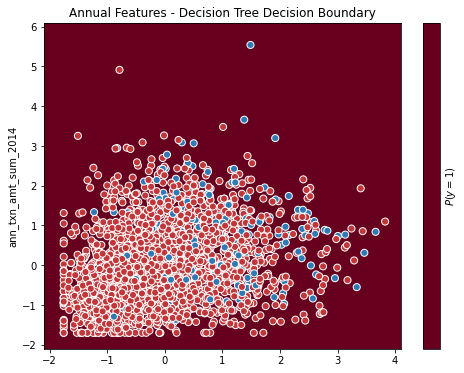

In [74]:
probs = dt.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual[50:,top_feature1_index], X_train_annual[50:,top_feature2_index], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Annual Features - Decision Tree Decision Boundary')
ax.set(aspect="auto",
       xlim=(-2.1, 4.1), ylim=(-2.1, 6.1),
       xlabel="", ylabel="ann_txn_amt_sum_2014")
plt.show()

# **PART 1C : RANDOM FOREST**

#### 1.1.4 Fit the training dataset and optimize the hyperparameters of the method

**Do not need to re-do steps 1-3**

In [75]:
from sklearn.ensemble import RandomForestClassifier
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
recall_train           = []
recall_test            = []

for i in max_depth_range:
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_annual)
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_annual)
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    recall_train.append(recall_score(y_train_annual, y_train_predicted))
    recall_test.append(recall_score(y_test_annual, y_test_predicted))

In [76]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'Recall_TRAIN': recall_train,
                          'Recall_TEST': recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,Recall_TRAIN,Recall_TEST,MAX_DEPTH
0,90.174292,0.000000,0.0,1
1,90.174292,0.000000,0.0,2
2,90.174292,0.000000,0.0,3
3,90.174292,0.000000,0.0,4
4,90.174292,0.000000,0.0,5
5,90.174292,0.010204,0.0,6


In [77]:
rf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_annual, y_train_annual)

#### 1.2.5 Plot coeffcient values or feature importance

**Same index issue as part A**

In [78]:
rf_feature_importances = rf.feature_importances_

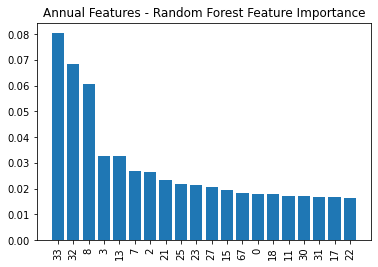

In [79]:
indices = np.argsort(rf_feature_importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
#names = [X_train_annual.columns[i] for i in indices]

plt.figure()
plt.title("Annual Features - Random Forest Feature Importance")
plt.bar(range(20), rf_feature_importances[indices])
plt.xticks(range(20), indices, rotation=90)
plt.show()

In [80]:
y_test_annual_proba = rf.predict_proba(X_test_annual)

<Figure size 432x288 with 0 Axes>

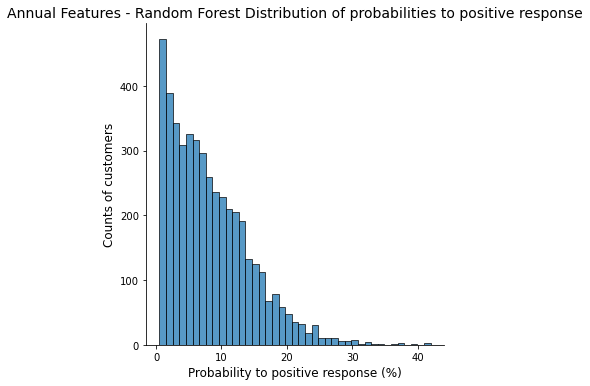

In [81]:
plt.figure()
sns.displot(data = y_test_annual_proba[:,1], x = 100*y_test_annual_proba[:,1])
plt.title('Annual Features - Random Forest Distribution of probabilities to positive response',fontsize=14)
plt.xlabel('Probability to positive response (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall. 

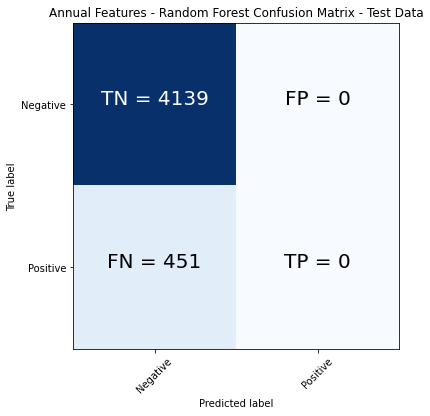

In [82]:
y_test_annual_predicted = rf.predict(X_test_annual)
cm = confusion_matrix(y_test_annual, y_test_annual_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Random Forest Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

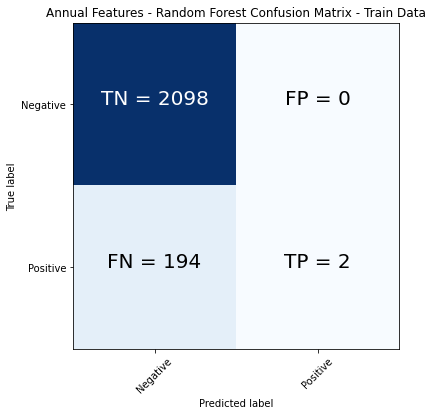

In [83]:
y_train_annual_predicted = rf.predict(X_train_annual)
cm = confusion_matrix(y_train_annual, y_train_annual_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Random Forest Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [84]:
# Scores for train set
scores_train = dt.predict_proba(X_train_annual)[:, 1]
# Scores for test set
scores_test = dt.predict_proba(X_test_annual)[:, 1]

In [85]:
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)

In [86]:
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

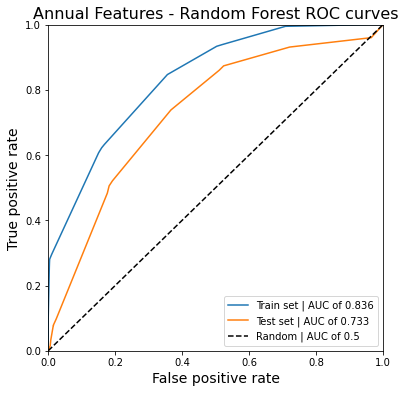

In [87]:
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Annual Features - Random Forest ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

In [88]:
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.90      1.00      0.95      4139
 Positive(1)       0.00      0.00      0.00       451

    accuracy                           0.90      4590
   macro avg       0.45      0.50      0.47      4590
weighted avg       0.81      0.90      0.86      4590



#### 1.2.8 Plot decision boundary for top 2 features.

In [89]:
min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

In [91]:
# top feature index
top_feature1_index = list(dt_feature_importances).index(np.sort(dt_feature_importances)[-1])
top_feature2_index = list(dt_feature_importances).index(np.sort(dt_feature_importances)[-2])

In [92]:
# top feature
top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

In [93]:
# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [94]:
print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature ann_txn_amt_sum_2014, min=-1.755266718463368, max=3.824668181429266
2nd top feature ann_txn_amt_sum_2013, min=-1.6977424959358869, max=5.53912436943854


In [95]:
xx, yy = np.mgrid[-5:981:109, -5:1323:147] 
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) 

median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 

median_inputs[:,28] = grid[:,0]
median_inputs[:,27] = grid[:,1]

(100, 2)


In [201]:
#probs = rf.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

#f, ax = plt.subplots(figsize=(8, 6))
#contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
#ax_c = f.colorbar(contour)
#ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0, .25, .5, .75, 1])

#ax.scatter(X_train_annual.iloc[50:,indices[0]], X_train_annual.iloc[50:,indices[1]], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
#ax.set_title('Annual Features - Random Forest Decision Boundary')
#ax.set(aspect="auto",
       xlim=(-5, 981), ylim=(-5, 1323),
       xlabel=names[0], ylabel=names[1])

#plt.show()

IndentationError: unexpected indent (<ipython-input-201-337bd8089a21>, line 5)

** this plot was not working **

## 1.2 Steps for each method -> **PART 2: MONTHLY** 

## **PART 2A: L1**

In [322]:

mth_rolling_features = pd.read_excel("mth_rolling_features.xlsx")
mth_rolling_features = mth_rolling_features.drop(mth_rolling_features.columns[0], axis=1)

mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel("mth_day_counts.xlsx")
mth_day_counts = mth_day_counts.drop(mth_day_counts.columns[0], axis=1)

days_since_last_txn = pd.read_excel("days_since_last_txn.xlsx")
days_since_last_txn = days_since_last_txn.drop(days_since_last_txn.columns[0], axis=1)

Retail_Data_Response = Retail_Data_Response.rename(columns={'customer_id': 'CLNT_NO'}) 

monthly_features_outputs = pd.merge(mth_rolling_features, mth_day_counts ,on=['CLNT_NO','ME_DT'])
monthly_features_outputs = pd.merge(monthly_features_outputs, days_since_last_txn, on=['CLNT_NO','ME_DT'])
monthly_features_outputs = pd.merge(Retail_Data_Response, monthly_features_outputs, on=['CLNT_NO'])

print ("Check if the number of columns correct:", 
       monthly_features_outputs.shape[1] == (mth_rolling_features .shape[1] + mth_day_counts.shape[1] + days_since_last_txn.shape[1] 
       + Retail_Data_Response.shape[1] - 5))

monthly_features_outputs 

Check if the number of columns correct: True


,CLNT_NO,response,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,...,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn
0,CS1112,0,2011-05-31,0,0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0,0,0,0,0,0,0,-10
1,CS1112,0,2011-06-30,56,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0,0,0,0,0,0,1,15
2,CS1112,0,2011-07-31,0,0,56.0,56.0,18.666667,1.0,1.0,...,0.0,0.000000,0,0,0,0,0,0,0,46
3,CS1112,0,2011-08-31,96,1,96.0,152.0,50.666667,1.0,2.0,...,0.0,0.000000,1,0,0,0,0,0,0,12
4,CS1112,0,2011-09-30,0,0,96.0,96.0,32.000000,1.0,1.0,...,0.0,0.000000,0,0,0,0,0,0,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,0,0,0.0,0.0,0.000000,0.0,0.0,...,4.0,0.333333,0,0,0,0,0,0,0,98
323544,CS9000,0,2014-12-31,0,0,0.0,0.0,0.000000,0.0,0.0,...,4.0,0.333333,0,0,0,0,0,0,0,129
323545,CS9000,0,2015-01-31,0,0,0.0,0.0,0.000000,0.0,0.0,...,3.0,0.250000,0,0,0,0,0,0,0,160
323546,CS9000,0,2015-02-28,34,1,34.0,34.0,11.333333,1.0,1.0,...,4.0,0.333333,0,0,1,0,0,0,0,188


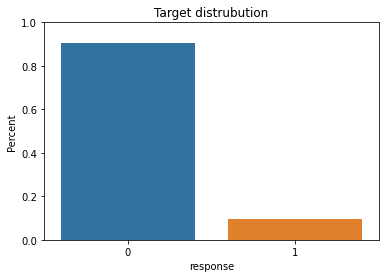

In [202]:
sns.barplot(x="response", y="response", data=monthly_features_outputs, estimator=lambda x: len(x) / len(monthly_features_outputs))
plt.ylabel("Percent")
plt.title('Target distrubution')
plt.ylim(0,1)
plt.show()

In [203]:
X_monthly = monthly_features_outputs.drop(['response','CLNT_NO','ME_DT'],1)
y_monthly = monthly_features_outputs.response

unique_elements, counts_elements = np.unique(y_monthly, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1]
 [293139  30409]]


In [204]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=2/3, random_state=1147)

unique_elements, counts_elements = np.unique(y_train_monthly, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the said array:
[[    0     1]
 [97742 10107]]


#### 1.2.3 Pre-Process data (Standard Scaling) standard scaling is needed for logistic regression because it it a sensitive model 

In [208]:
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.transform(X_test_monthly)

#### 1.2.4 Fit the training dataset and optimize the hyperparameters of the method

In [209]:
# Parameters to Track
c_range = [0.01,0.1,1,10,100,1000]
estimator_c = []
accuracy_normalized = []
recall_train = []
recall_test = []

for i in range(6):
    estimator_c.append(LogisticRegression(penalty='l1', solver='liblinear', random_state=0, C = c_range[i]))
    estimator_c[i].fit(X_train_monthly_scaled, y_train_monthly)
    y_train_predicted = estimator_c[i].predict(X_train_monthly_scaled)
    y_test_predicted = estimator_c[i].predict(X_test_monthly_scaled)
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    recall_train.append(recall_score(y_train_monthly, y_train_predicted))
    recall_test.append(recall_score(y_test_monthly, y_test_predicted))

performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'Recall_TRAIN': recall_train,
                          'Recall_TEST': recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['C'] = c_range
performance_df

,ACCURACY,Recall_TRAIN,Recall_TEST,C
0,90.58781,0.0,0.0,0.01
1,90.58781,0.0,0.0,0.10
2,90.58781,0.0,0.0,1.00
3,90.58781,0.0,0.0,10.00
4,90.58781,0.0,0.0,100.00
5,90.58781,0.0,0.0,1000.00


#### 1.2.5 Plot coeffcient values or feature importance

In [210]:
LogReg = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=0).fit(X_train_monthly_scaled, y_train_monthly)
importances = LogReg.coef_[0]

In [211]:
indices = np.argsort(importances)[::-1]

**column names i couldnt get it to work have to use index's unfortunatly** 

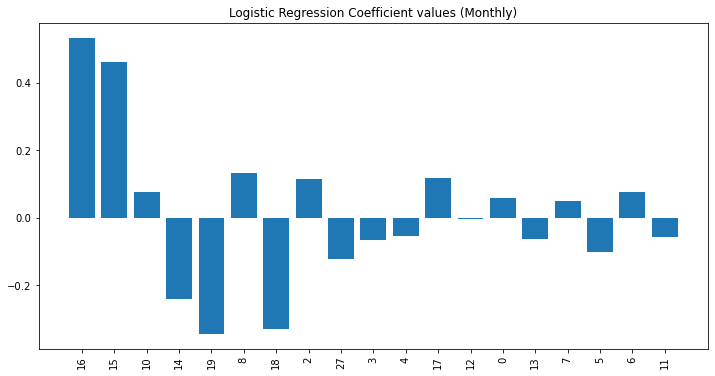

In [323]:
coef = np.array([importances[i] for i in indices])
coef = pd.DataFrame(coef.reshape(1,-1), columns=indices)
coef = coef.loc[:, (coef != 0).any(axis=0)]

plt.figure(figsize=(12,6))
plt.title("Logistic Regression Coefficient values (Monthly)")
plt.bar(range(coef.shape[1]), coef.values[0])
plt.xticks(range(coef.shape[1]), coef.columns, rotation=90)
plt.show()

 #### 1.2.6 Plot probability distribution for test set

In [213]:
y_test_monthly_proba = LogReg.predict_proba(X_test_monthly_scaled)

<Figure size 432x288 with 0 Axes>

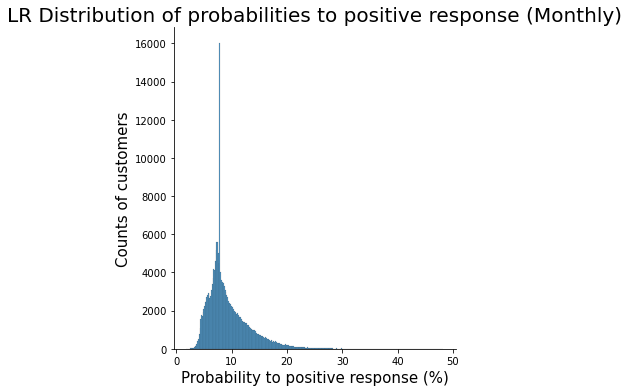

In [214]:
plt.figure()
sns.displot(data = y_test_monthly_proba[:,1], x = 100*y_test_monthly_proba[:,1])
plt.title('LR Distribution of probabilities to positive response (Monthly)',fontsize=20)
plt.xlabel('Probability to positive response (%)',fontsize=15)
plt.ylabel('Counts of customers', fontsize=15)
plt.show()

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall

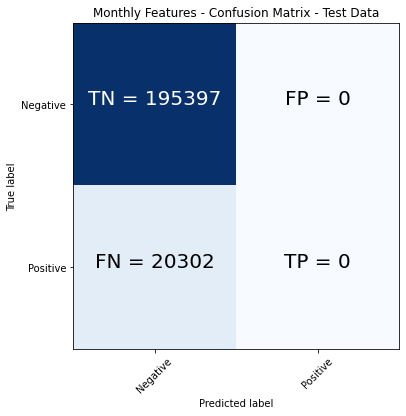

In [218]:
y_test_monthly_predicted = LogReg.predict(X_test_monthly_scaled)
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [223]:
# Scores for train set
scores_train = LogReg.predict_proba(X_train_monthly_scaled)[:, 1]
# Scores for test set
scores_test = LogReg.predict_proba(X_test_monthly_scaled)[:, 1]

In [225]:
# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

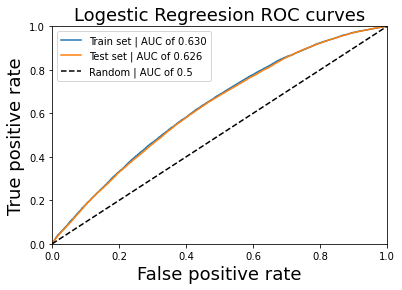

In [226]:
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Logestic Regreesion ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [227]:
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.91      1.00      0.95    195397
 Positive(1)       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



#### 1.2.8 Plot decision boundary for top 2 features.

In [228]:
min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

In [229]:
top_feature1_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-1])
top_feature2_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-2])

In [230]:
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

In [231]:
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]

In [232]:
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [233]:
print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_sum_12M, min=-1.3042030288026143, max=5.586586966127264
2nd top feature cnt_Tuesday, min=-0.23577711150388977, max=12.448788418218262


In [234]:
xx, yy = np.mgrid[-2.1:5.1, -2.1:5.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape)  

grid dimenshion: (64, 2)


In [240]:

#median_inputs = np.ones((grid.shape[0], X_train_monthly.shape[1])) * np.median(X_train_monthly, axis=0) 


#median_inputs[:,top_feature1_index] = grid[:,0]
#median_inputs[:,top_feature2_index] = grid[:,1]
probs = lr.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# plot decision boundary
#f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

#ax.scatter(X_train_monthly[50:,top_feature1_index], X_train_monthly[50:, top_feature2_index], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

#ax.set(aspect="auto",
       xlim=(-2, 5), ylim=(-2, 5),
       xlabel=str(top_feature1), ylabel=str(top_feature2))

#plt.show()

IndentationError: unexpected indent (<ipython-input-240-c4f55fb85188>, line 19)

## **PART 2B: Decision Tree**

#### 1.1.4 Fit the training dataset and optimize the hyperparameters of the method

**Do not need to re-do steps 1-3**

In [241]:
# parameters that I want to track 
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
recall_train           = []
recall_test            = []

for i in max_depth_range:
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_monthly)
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_monthly)
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))

    recall_train.append(recall_score(y_train_monthly, y_train_predicted))
    recall_test.append(recall_score(y_test_monthly, y_test_predicted))

performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'Recall_TRAIN': recall_train,
                          'Recall_TEST': recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df


,ACCURACY,Recall_TRAIN,Recall_TEST,MAX_DEPTH
0,90.587810,0.000000,0.000000,1
1,90.587810,0.000000,0.000000,2
2,90.587810,0.000000,0.000000,3
3,90.586419,0.000495,0.000049,4
4,90.571584,0.003364,0.001379,5
5,90.556748,0.005838,0.001724,6


#### 1.2.5 Plot coeffcient values or feature importance

In [242]:
dt = DecisionTreeClassifier(max_depth=6, random_state=0).fit(X_train_monthly, y_train_monthly)

In [243]:
dt_feature_importances = dt.feature_importances_

#### 1.2.6 Plot probability distribution for test set

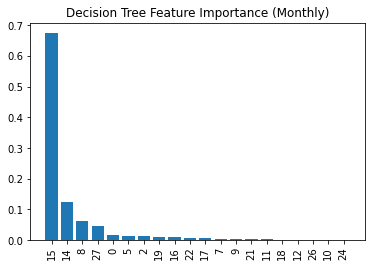

In [244]:
indices = np.argsort(dt_feature_importances)[::-1][:20]
#names = [X_train_monthly.columns[i] for i in indices]
plt.figure()
plt.title("Decision Tree Feature Importance (Monthly)")
plt.bar(range(20), dt_feature_importances[indices])
plt.xticks(range(20), indices, rotation=90)
plt.show()

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall

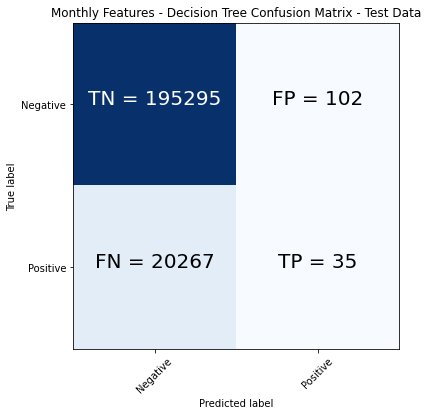

In [247]:
y_test_monthly_predicted = dt.predict(X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Decision Tree Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [250]:
# Scores for train set
scores_train = dt.predict_proba(X_train_monthly)[:, 1]
# Scores for test set
scores_test = dt.predict_proba(X_test_monthly)[:, 1]

In [251]:
# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

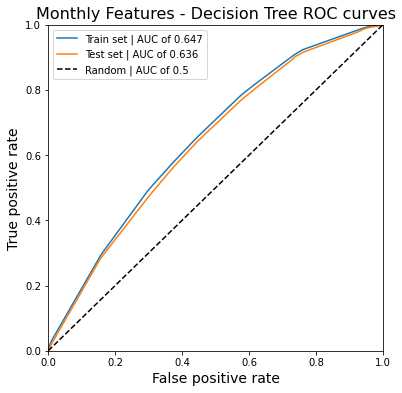

In [252]:
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Monthly Features - Decision Tree ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

In [253]:
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.91      1.00      0.95    195397
 Positive(1)       0.26      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.58      0.50      0.48    215699
weighted avg       0.84      0.91      0.86    215699



#### 1.2.8 Plot decision boundary for top 2 features.

In [254]:
min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

In [255]:
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

In [256]:
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

In [257]:
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]

In [258]:
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [259]:
print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_max_12M, min=-1.1658179438201839, max=4.862714417611843
2nd top feature amt_mean_12M, min=-1.1658179438201837, max=4.862714417611841


In [260]:
xx, yy = np.mgrid[-2.1:5.1, -2.1:6.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape

grid dimenshion: (72, 2)


In [269]:
#median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 

# Replace the 5th and 4th column with the values of the grid
#median_inputs[:,15] = grid[:,0]
#median_inputs[:,16] = grid[:,1]

#probs = dt.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

#f, ax = plt.subplots(figsize=(8, 6))
#contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
#ax_c = f.colorbar(contour)
#ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0, .25, .5, .75, 1])

#ax.scatter(X_train_monthly.iloc[50:,15], X_train_monthly.iloc[50:,16], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
#ax.set_title('Monthly Features - Decision Tree Decision Boundary')
#ax.set(aspect="auto",
       xlim=(-5, 112), ylim=(-5, 460),
       xlabel=names[0], ylabel=names[1])

#plt.show()

IndentationError: unexpected indent (<ipython-input-269-bbe775ee892c>, line 11)

## **PART 2C: RANDOM FORESTS**

#### 1.1.4 Fit the training dataset and optimize the hyperparameters of the method

**Do not need to re-do steps 1-3**

In [318]:
from sklearn.ensemble import RandomForestClassifier
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
recall_train           = []
recall_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_monthly)
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_monthly)
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    recall_train.append(recall_score(y_train_monthly, y_train_predicted))
    recall_test.append(recall_score(y_test_monthly, y_test_predicted))

In [272]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'Recall_TRAIN': recall_train,
                          'Recall_TEST': recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,Recall_TRAIN,Recall_TEST,MAX_DEPTH
0,90.58781,0.000000,0.0,1
1,90.58781,0.000000,0.0,2
2,90.58781,0.000000,0.0,3
3,90.58781,0.000000,0.0,4
4,90.58781,0.000000,0.0,5
5,90.58781,0.000099,0.0,6


In [274]:
rf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_monthly, y_train_monthly)

In [278]:
rf_feature_importances = rf.feature_importances_

In [279]:
indices = np.argsort(rf_feature_importances)[::-1][:20]

#### 1.2.5 Plot coeffcient values or feature importance

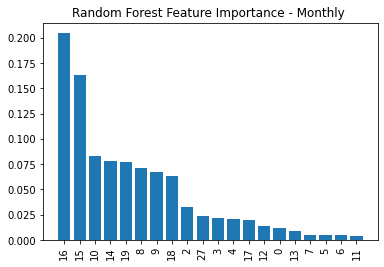

In [316]:
plt.figure()
plt.title("Random Forest Feature Importance - Monthly ")
plt.bar(range(20), rf_feature_importances[indices])
plt.xticks(range(20), indices, rotation=90)
plt.show()

 #### 1.2.6 Plot probability distribution for test set

<Figure size 432x288 with 0 Axes>

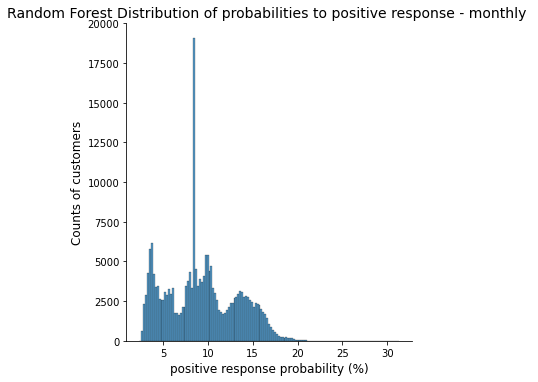

In [315]:
y_test_monthly_proba = rf.predict_proba(X_test_monthly)

plt.figure()
sns.displot(data = y_test_monthly_proba[:,1], x = 100*y_test_monthly_proba[:,1])
plt.title('Random Forest Distribution of probabilities to positive response - monthly ',fontsize=14)
plt.xlabel('positive response probability (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

#### 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall

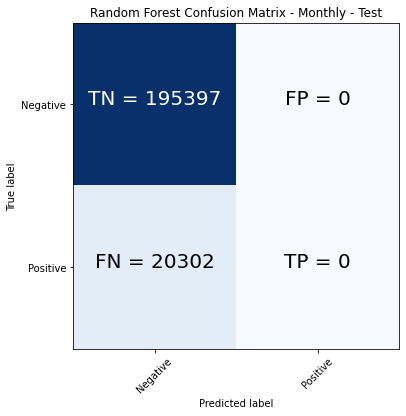

In [314]:
y_test_monthly_predicted = rf.predict(X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Random Forest Confusion Matrix - Monthly - Test')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

#### 1.2.7.1 ROC Curves - Train/Test Set

In [313]:

scores_train = rf.predict_proba(X_train_monthly)[:, 1]
scores_test = rf.predict_proba(X_test_monthly)[:, 1]

In [312]:
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

#### 1.2.7.2 Plot ROC Curve

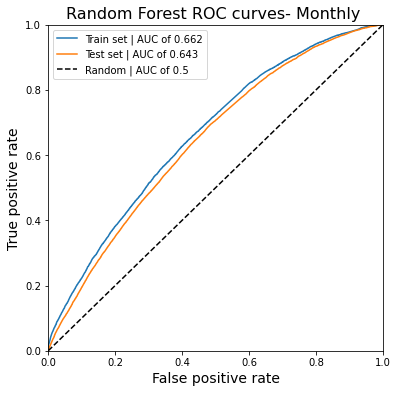

In [311]:
# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forest ROC curves- Monthly ', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

In [292]:
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative = 0', 'Positive = 1']))

              precision    recall  f1-score   support

Negative = 0       0.91      1.00      0.95    195397
Positive = 1       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



#### 1.2.8 Plot decision boundary for top 2 features.

In [293]:
min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

In [294]:
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

In [295]:
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

In [296]:
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]

In [297]:
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

In [298]:
print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_max_12M, min=-1.1658179438201839, max=4.862714417611843
2nd top feature amt_mean_12M, min=-1.1658179438201837, max=4.862714417611841


In [310]:
xx, yy = np.mgrid[-5:981:109, -5:1323:147]
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape)

median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 

median_inputs[:,28] = grid[:,0]
median_inputs[:,27] = grid[:,1]

(100, 2)


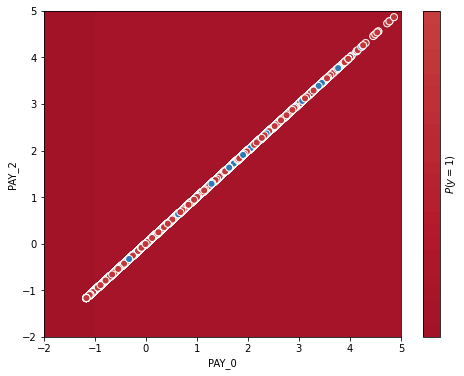

In [308]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly[50:,top_feature1_index], X_train_monthly[50:,top_feature2_index], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(aspect="auto",
       xlim=(-2, 5), ylim=(-2, 5),
       xlabel="PAY_0", ylabel="PAY_2")
plt.show()

## 1.3 Comparison of Methods

**Comparison of models looking at the classification report done for each model for both Annual and Monthly.**

***I do recognise that there are many issues with the data above, for some reason i had the most trouble pre/processing my data correctly [ especially for the monthly data sets]  i think it might have been an issue with the saved files from assignment 5...it didnt recognise some columns even though they were present. For these reasons the data in the chart below is not very accurate but i will make a conclusion as if it were.***



| Feature | Model | Precision | Recall | Accuracy | Testing AUC | Training AUC | 
| --- | --- | --- | -- | -- | -- | -- |
| Annual | L1 | .21 | 0.03 | 0.89 | 0.733 | 0.822 |
|  | Decision Tree| 0.30 | 0.07 | 0.89 | 0.733 | 0.836 |
|  | Random Forests | 0.0 | 0.0 | 0.9 | 0.733 | 0.836 |
| Monthly | Gaussian | 0.0 | 0.0 | 0.91 | 0.626 | 0.630 |
|  | Decision Tree | .26 | 0.0 | 0.91 | 0.636 | 0.647 |
|  | Random Forests | .0 | 0.0 | 0.91 | 0.643 | 0.662 |








**Compare the two feature engineering (annual and monthly) and the three modeling ap-
proaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8.**

Probability distribution/Confusion Matrix/ROC/Precision/Recall and Features of Importance were used to model the information/performance. A confusion matrix provides a summary of the predictive results in a classification problem. Correct and incorrect predictions are summarized in a table with their values and broken down by each class. Although there were high values of TN (Predicted NO/Actual NO) there was also a high values of FN (False Negatives - Predicted no/actual yes). Recall is the ratio of the relevant results returned by the search engine to the total number of the relevant results that could have been returned -> most of the models that have a precision 0> ("high") have a low recall meaning there is a very low % of correctness. Decision Tree algorithms and L1 - Regression are sentitive to class imbalance, if the decision tree algorithm is unbalanced then the random forest algorithm will also be imbalanced as it is based on decision trees. 

The ROC curve shows the trade-off between sensitivity and specificity, curves closer to the top left (AUC is high) suggest a better performance of the model. 
The testing AUC values for the annual model feature are all the same, which i think is a mistake as that doesnt make sense with the variability in my data and the models themselves. Monthly Feature AUC's are lower than Annual features indicating that there was an inability to classify the two groups it was attempting to model accuratly. 

**Which combination of feature engineering and modeling approach do you select as the best to deploy in a
production environment and why?**

Although i know my confusion matrix outputs are probably innacurate, i will choose decision tree model under the annual features as the best choice to deplot in a production environment because it has lowest FN, as well it has higher AUC then any of the monthly models and is close to the comparative training AUC. It has the highest recall value as well as the highest precision.

It seems like the models chosen do not do a good job at accuratly predicting well on the positive response (TP) as these values were lower on every confusion matrix compares to (TF). Possibly alter the method of data digestion somehow or maybe this dataset/aggregated charts are inherently just not suitable for this type of simulation.  